In [17]:
import numpy as np
from matplotlib import pyplot as plt

from scipy.interpolate import interp1d,InterpolatedUnivariateSpline
from scipy.integrate import cumtrapz, quad
from scipy.special import erf

from WIMpy import DMUtils as DMU
import paleopy as paleopy
import swordfish as sf # probably useless

from pylab import *

In [18]:
import scipy as sp
import scipy.interpolate

def log_interp1d(xx, yy, kind='linear'):
    logx = np.log10(xx)
    logy = np.log10(yy)
    lin_interp = sp.interpolate.interp1d(logx, logy, kind=kind, fill_value='extrapolate')
    log_interp = lambda zz: np.power(10.0, lin_interp(np.log10(zz)))
    return log_interp

In [19]:
# loading the atmospheric neutrino information

x_neut, flux_neut = np.loadtxt("Data/Atmneutrino.txt", usecols = (0,1), delimiter=' ',  unpack='true')
Fneut = log_interp1d(x_neut*1e6, flux_neut/(x_neut*1e6)/1e3)

In [20]:
n_bins = 75
x_min = 0 #log scale in nm
x_max = 5.2 #log scale in nm

h_min = 0
h_max = 1e5
h_bins = 1000000

rho   = 2.15 # g/cm3
mineralname = "Halite"
Ufrac = 5*1e4 # multiplied per 0.1 ppb

In [21]:
colors = ['mediumblue', 'steelblue', 'darkorange', 'firebrick', 'forestgreen', 'springgreen', 'chocolate']
linestyles = ['-', '-', '-', '-', '-', '-', '-']
labels = ['$\\upmu$ sea level', '$\\upmu$ from SN (20 $\\mathrm{pc}$)', '$\\upmu$ 1500 m.w.e.', '$\\upmu$ from SN (0 $\\mathrm{pc}$)','$^{238}\\text{U}$ spontaneous fission', 'Atmospheric neutrinos', 'Neutrons']
size = 2
font_size = 30
delay = 5

In [22]:
def loadSpectrum(mineral):
    
    x_bins = np.logspace(x_min,x_max,n_bins)
    x_width = np.diff(x_bins)
    x = x_bins[:-1] + x_width/2.
    
    #Returns in events/kg/Myr/nm
    nu_list = ["DSNB", "atm", "hep", "8B", "15O", "17F", "13N", "pep", "pp", "7Be-384", 
               "7Be-861", "K", "U", "235U", "Th", "1987IA", "CCSN"]    
    E_list = np.logspace(-3, 3, 5000) # keV
    
    
    dRdx = []
    
    # load the neutrino recoil
    for j, nu_source in enumerate(nu_list):
        dRdx_temp = np.zeros_like(x)
        for i, nuc in enumerate(mineral.nuclei):
            if (nuc != "H"):
                xtemp = mineral.Etox_nuclei[nuc](E_list)
                dRdx_nuc = (np.vectorize(DMU.dRdE_CEvNS)(E_list, mineral.N_p[i], mineral.N_n[i], flux_name=nu_source)
                                                            *mineral.dEdx_nuclei[nuc](xtemp))
                temp_interp = interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
                dRdx_temp += mineral.ratio_nuclei[nuc]*temp_interp(x)
        dRdx.append(dRdx_temp*1e6*365+1e-20)
    
    # solar neutrinos
    solar = np.zeros(n_bins-1)
    dRdx.append(solar)
    
    for i in range(n_bins-1):
        for j in range(9):
            dRdx[17][i] += dRdx[j+2][i]
        
    # geoneutrinos
    geo = np.zeros(n_bins-1)
    dRdx.append(geo)
    
    for i in range(n_bins-1):
        for j in range(4):
            dRdx[18][i] += dRdx[j+11][i]
    
    return dRdx

In [23]:
def plotSpectrum(mineral, dRdx, name, Ufrac):
    
    x_bins = np.logspace(x_min,x_max,n_bins)
    
    plt.figure(figsize=(13,8))
    
    x_Th = mineral.xT_Thorium()
    x,y  = np.loadtxt("Data/"+name+"/"+name+"_fission.dat", usecols = (0,1), unpack='true')
    fiss = interp1d(x, y, fill_value='extrapolate')
    
    omega = 2*np.pi/3 # integral in theta, phi
    

    # signal part
    p1, = plt.loglog(x_bins[:-1], mineral.dRdx_muons_new(x_bins, "resconi", delay=delay, compl=True)/(0.05-delay*1e-3), 
                     label=r'$\mu$ sea level ', linewidth = size, color = colors[0], linestyle = linestyles[0])
    p2, = plt.loglog(x_bins[:-1], mineral.dRdx_muons_new(x_bins, "SN20pc", delay=delay, compl=True)/(0.05-delay*1e-3), 
                     linestyle = linestyles[1], linewidth = size, color = colors[1], label=r'$\mu$ from SN (20 pc)')
    p3, = plt.loglog(x_bins[:-1], mineral.dRdx_muons_new(x_bins, "SN50pc", delay=delay, compl=True)/(0.05-delay*1e-3), 
                      label=r'$\mu$ from SN (50 pc)', color = "purple", linewidth = size, linestyle = linestyles[3])
    p4, = plt.loglog(x_bins[:-1], mineral.dRdx_muons_new(x_bins, "SN100pc", delay=delay, compl=True)/(0.05-delay*1e-3), 
                     label=r'$\mu$ from SN (100 pc)', color = colors[3], linewidth = size, linestyle = linestyles[3])
    
    # background part
    p5, = plt.loglog(x_bins[:-1], mineral.dRdx_muons_new(x_bins, "resconi_overburden"), label=r'$\mu$ 1.75 km.w.e.', 
                     color = colors[2], linewidth = size, linestyle = linestyles[2])
    p6, = plt.loglog(x_bins[:-1], Ufrac*fiss(x_bins[:-1]),label=r'SFFs from $^{238}U$', color = colors[4], 
                     linewidth = size, linestyle = linestyles[4])
    p7, = plt.loglog(x_neut*1e6, flux_neut/(x_neut*1e6)/1e3, label=r'Atmospheric neutrinos', color = colors[5], 
                     linewidth = size, linestyle = linestyles[5])
    p8, = plt.loglog(x_bins[:-1], mineral.dRdx_neutrons(x_bins), label='Neutrons background', color = colors[6], 
                     linewidth = size, linestyle = linestyles[6])

    plt.legend(fontsize=22, loc = 'upper left',ncol=2)
    
    l1 = legend([p1, p2, p3, p4], ["muon flux", 'sn 20 pc', "sn 50 pc", 'sn 100 pc'], loc='upper right', 
                bbox_to_anchor=(0.48, 1),title = r'$\textbf{Signal}$', fontsize = 23)
    l2 = legend([p5, p6, p7, p8], ["$\\mu$ at $1.75\,\\text{km.w.e.}$", "SFFs from $^{238}U$", "atmospheric neutrinos",
            "Neutrons"], loc='upper left', bbox_to_anchor=(0.48, 1), fontsize = 23,title = r'$\textbf{Background}$')
    gca().add_artist(l1)

    ax = plt.gca()
    
    plt.ylabel(r"d$\textit{R}$/d$\textit{x}$ [$\mathrm{nm}^{-1}\,\mathrm{kg}^{-1}\,\mathrm{Myr}^{-1}$]",fontsize=font_size)
    plt.xlabel(r"$\textit{x}$ [$\mathrm{nm}$]",fontsize=font_size)
    plt.xlim(0.9*1e3,10.5*1e4)
    plt.ylim(2.1*1e-3,7.9*1e12)
    
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    
    ax.tick_params(axis = 'both', direction='in', length=9, width=2.5, which = 'major')
    ax.tick_params(axis = 'both', direction='in', length=5, width=1.5, which = 'minor')

    plt.savefig("plot_overburden/dRdx_" + mineral.name + ".png",bbox_inches="tight")

    plt.show()

In [24]:
#print(mineral.dRdx_muons(x_bins, 0))
#print(mineral.dRdx_muons(x_bins, 7))
#print(mineral.dRdx_muons(x_bins, 7)/mineral.dRdx_muons(x_bins, 0))

Mineral name: Halite
    N_nuclei: 2
    Molar mass: 58.45  g/mol
    nucleus 	*	 abun.  *	 (N_p, N_n)
 **************************************************
    Na		*	0.39349871685201027	*	(11.0, 12.0)
    Cl		*	0.6065012831479898	*	(17.0, 18.45)
Plotting SRIM data for Halite:


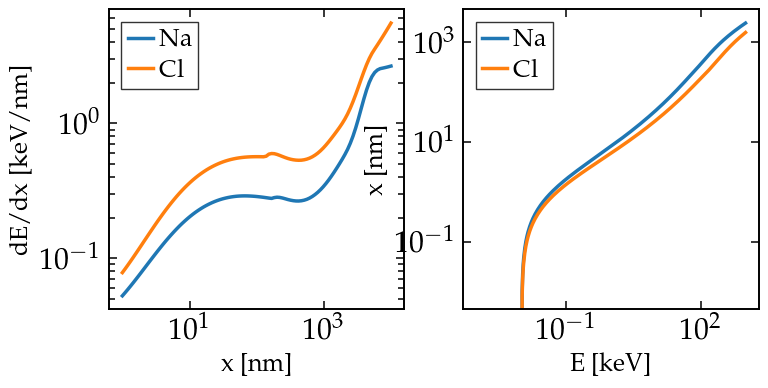

In [25]:
rho   = 2.15 # g/cm3
mineralname = "Halite"
mineral = paleopy.Mineral("Halite", muon="true", water="true")
mineral.showProperties()
mineral.showSRIM()

In [26]:
dRdx = []
dRdx = loadSpectrum(mineral)

In [27]:
x_bins = np.logspace(x_min,x_max,n_bins)
x_width = np.diff(x_bins)
x_mid = x_bins[:-1] + x_width/2    

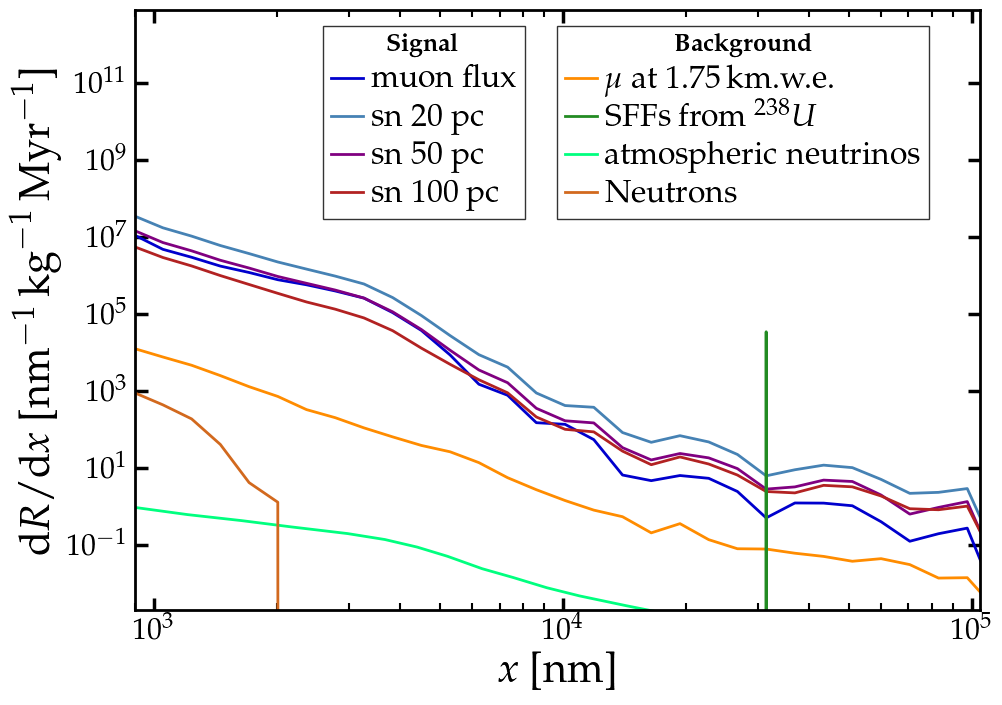

In [28]:
Ufrac = 5*1e4
plotSpectrum(mineral, dRdx, mineralname, Ufrac)

In [29]:
def Integral(dRdx, x_bins):
    
    x_width_all = np.diff(x_bins)
    x_mid_all = x_bins[:-1] + x_width_all/2.
    
    dRdx_interp = interp1d(x_mid_all, dRdx, bounds_error=False, fill_value=0.0)
    integral = []
    for i in range(len(x_bins)-1):
        integral.append(quad(dRdx_interp, x_bins[i], x_bins[i+1])[0])
        
    return np.array(integral)


def IntegralTh(x_bins):
    
    x_Th = mineral.xT_Thorium()
    x = np.linspace(h_min,h_max,h_bins)
    
    integral_Th = []
    
    for i in range(len(x_bins)-1):
        if(x_Th>=x_bins[i] and x_bins[i+1]>x_Th):
            integral_Th.append(mineral.norm_Thorium(T=1e7))
        else: integral_Th.append(0)
        
    return np.array(integral_Th)


def IntegralSSF(name, x_bins, Ufrac = 5*1e4):
    
    x,y  = np.loadtxt("Data/"+name+"/"+name+"_fission.dat", usecols = (0,1), unpack='true')
    fiss = interp1d(x, Ufrac*y, fill_value='extrapolate')
    
    integral_SSF = []
    for i in range(len(x_bins)-1):
        integral_SSF.append(quad(fiss,x_bins[i],x_bins[i+1])[0])
    return np.array(integral_SSF)

In [30]:
DSNB = Integral(dRdx[0],x_bins)
Atm = Integral(dRdx[1],x_bins)
Solar = Integral(dRdx[17],x_bins)
Geo = Integral(dRdx[18],x_bins)
SSF = IntegralSSF('Halite',x_bins)
Th = IntegralTh(x_bins)

In [31]:
delay = 5
fast = True

x_width_all = np.diff(x_bins)
x_mid_all = x_bins[:-1] + x_width_all/2.

Neut = []
muon = []
muon_SN100pc = []
muon_SN50pc = []
muon_deep = []
muon_deep_lowedge = []
muon_deep_upedge = []
muon_SN20pc = []
Atm = []

dRdx_interp_neut = interp1d(x_mid_all, mineral.dRdx_neutrons(x_bins), bounds_error=False, fill_value=0.0)
dRdx_interp_muon = interp1d(x_mid_all, mineral.dRdx_muons_new(x_bins, "resconi", delay=delay, compl=True, fast=fast), bounds_error=False, fill_value=0.0)
dRdx_interp_muon_deep = interp1d(x_mid_all, mineral.dRdx_muons_new(x_bins, "resconi_overburden_fast"), bounds_error=False, fill_value=0.0)
dRdx_interp_muon_deep_lowedge = interp1d(x_mid_all, mineral.dRdx_muons_new(x_bins, "resconi_overburden_fast_lowedge"), bounds_error=False, fill_value=0.0)
dRdx_interp_muon_deep_upedge = interp1d(x_mid_all, mineral.dRdx_muons_new(x_bins, "resconi_overburden_fast_upedge"), bounds_error=False, fill_value=0.0)


dRdx_interp_muon_SN20pc = interp1d(x_mid_all, mineral.dRdx_muons_new(x_bins, "SN20pc", delay=delay, compl=True, fast=fast), bounds_error=False, fill_value=0.0)
dRdx_interp_muon_SN100pc = interp1d(x_mid_all, mineral.dRdx_muons_new(x_bins, "SN100pc", delay=delay, compl=True, fast=fast), bounds_error=False, fill_value=0.0)
dRdx_interp_muon_SN50pc = interp1d(x_mid_all, mineral.dRdx_muons_new(x_bins, "SN50pc", delay=delay, compl=True, fast=fast), bounds_error=False, fill_value=0.0)

for i in range(len(x_bins)-1):
    Neut.append(quad(dRdx_interp_neut,x_bins[i],x_bins[i+1])[0])
    muon.append(quad(dRdx_interp_muon,x_bins[i],x_bins[i+1])[0])
    muon_deep.append(quad(dRdx_interp_muon_deep,x_bins[i],x_bins[i+1])[0])
    muon_deep_lowedge.append(quad(dRdx_interp_muon_deep_lowedge,x_bins[i],x_bins[i+1])[0])
    muon_deep_upedge.append(quad(dRdx_interp_muon_deep_upedge,x_bins[i],x_bins[i+1])[0])
    muon_SN20pc.append(quad(dRdx_interp_muon_SN20pc,x_bins[i],x_bins[i+1])[0])
    muon_SN50pc.append(quad(dRdx_interp_muon_SN50pc,x_bins[i],x_bins[i+1])[0])
    muon_SN100pc.append(quad(dRdx_interp_muon_SN100pc,x_bins[i],x_bins[i+1])[0])
    Atm.append(quad(Fneut, x_bins[i], x_bins[i+1])[0])
    
Neut = np.array(Neut)
muon = np.array(muon)
muon_deep = np.array(muon_deep)
muon_deep_lowedge = np.array(muon_deep_lowedge)
muon_deep_upedge = np.array(muon_deep_upedge)
muon_SN20pc = np.array(muon_SN20pc)
muon_SN50pc = np.array(muon_SN50pc)
muon_SN100pc = np.array(muon_SN100pc)
Atm = np.array(Atm)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.36581448e+04 3.64980267e+05 3.33255592e+05 3.29300418e+05
 3.71523884e+05 6.46801512e+05 9.47334693e+05 1.34178429e+06
 1.80482458e+06 2.27313675e+06 3.40602351e+06 4.64311373e+06
 6.65756265e+06 9.04143160e+06 1.35363805e+07 3.81334039e+07
 1.10497480e+08 9.64874432e+07 7.30725932e+07 6.09797770e+07
 6.18581349e+07 1.39310271e+08 2.24910609e+08 1.58422416e+08
 1.07255231e+08 7.33254300e+07 5.22628113e+07 3.75466789e+07
 2.84120313e+07 2.18557929e+07 1.58894502e+07 8.90832122e+06
 3.85974223e+06 1.43065507e+06 5.34997616e+05 2.57910264e+05
 8.78249456e+04 3.86347366e+04 3.32364835e+04 1.32990596e+04
 7.11366078e+03 9.83073115e+03 8.64834676e+03 5.13206884e+03
 2.20537372e+03 2.650788

In [32]:
def plotInt(x_bins, mass, time, time1=0.27, Ufrac=5*1e4):
    
    plt.figure(figsize=(13,8))
    
    xx = np.array(x_bins[:-1]) + np.diff(x_bins)/2.
    
    Neut_hist = Neut*mass*time
    muon_hist = muon*mass
    muon_deep_hist = muon_deep*mass*(time-time1)
    muon_deep_hist_lowedge = muon_deep_lowedge*mass*(time-time1)
    muon_deep_hist_upedge = muon_deep_upedge*mass*(time-time1)
    muon_SN20pc_hist = muon_SN20pc*mass
    muon_SN50pc_hist = muon_SN50pc*mass
    muon_SN100pc_hist = muon_SN100pc*mass
    Atm_hist =  Atm*mass*time1  
    
    X = []
    SSFhist = []
    
    for i in range(len(x_bins)-1):
        x = np.linspace(x_bins[i], x_bins[i+1]-0.001*x_bins[i], 100)
        for j in range(100):
            SSFhist.append(SSF[i]*mass*time)
            X.append(x[j])
    
    labels = ['$\\upmu$ sea level', '$\\upmu$ sea level +' + "\n" +  '$\\upmu$ from SN (20 $\\mathrm{pc}$)', 
              '$\\upmu$ sea level +' + "\n" +  '$\\upmu$ from SN (100 $\\mathrm{pc}$)', '$\\upmu$ 1500 m.w.e.', 
              '$^{238}\\text{U}$ spontaneous fission', 'Atmospheric neutrinos', 'Neutrons']
    
    p5, = plt.loglog(X,SSFhist,label=r'$^{238}U$ spontaneous fission', color = [230./255.,159./255.,0.], 
                     linestyle = linestyles[4], linewidth = size)
    
    p1, = plt.step(xx, muon_hist, color = "blue", linestyle = linestyles[0], linewidth = size, where = 'mid' )
    p9, = plt.step(xx, muon_hist+muon_SN100pc_hist, color = "steelblue", linestyle = linestyles[0], 
                   linewidth = size, where = 'mid')
    p3, = plt.step(xx, muon_hist+muon_SN20pc_hist, color = "darkred", linestyle = linestyles[0], 
                   linewidth = size, where = 'mid')
    p30, = plt.step(xx, muon_hist+muon_SN50pc_hist, color = "purple", linestyle = linestyles[0], 
                    linewidth = size, where = 'mid')
    
    # p5 = plt.fill_between(xx,muon_hist+0.1*muon_hist,muon_hist-0.1*muon_hist,color = [0.,0.,0.],alpha=0.6, step='mid')
    # p7 = plt.fill_between(xx,muon_hist+0.1*muon_hist+muon_SN20pc_hist+0.1*muon_SN20pc_hist,muon_hist-0.1*muon_hist+muon_SN20pc_hist-0.1*muon_SN20pc_hist,color = [0.,114./255.,178./255.],alpha=0.6, step='mid')
    # p10 = plt.fill_between(xx,muon_hist+0.1*muon_hist+muon_SN100pc_hist+0.1*muon_SN100pc_hist,muon_hist-0.1*muon_hist+muon_SN100pc_hist-0.1*muon_SN100pc_hist,color = [240./255.,228./255.,66./255.],alpha=0.6, step='mid')
    # p8  = plt.fill_between(X,np.array(muonhistgal)+np.array(muonhistgalerror),np.array(muonhistgal)-np.array(muonhistgalerror),color = colors[3],alpha=0.6)
    
    p4, = plt.step(xx, muon_deep_hist, color = [213./255.,94./255.,0.], linestyle = linestyles[4], 
                   linewidth = size, where='mid')
    p40 = plt.fill_between(xx, muon_deep_hist_lowedge, muon_deep_hist_upedge, color = [213./255.,94./255.,0.], 
                           step='mid', alpha=0.6)
    
    p6, = plt.step(xx, Atm_hist, label=r'Atmospheric neutrinos', color = [0.,114./255.,178./255.], 
                   linestyle = linestyles[5], linewidth = size, where='mid')
    p7, = plt.step(xx, Neut_hist,label=r'Neutrons', color = [204./255,121./255.,167./255.], 
                   linestyle = linestyles[6], linewidth = size, where='mid')
    

    # l1 = legend([p1, p3, p9], ["Scenario A", 'Scenario B', 'Scenario C'], loc='upper right', bbox_to_anchor=(0.67, 1.),title = r'$\textbf{Signal}$', fontsize = 23, frameon=False)
    l1 = legend([p1, p3, p30, p9], ["today", 'today + 20 pc SN', 'today + 50 pc SN', "today + 100 pc SN"], 
                loc='upper right', bbox_to_anchor=(0.48, 1.),title = r'$\textbf{Signal}$', fontsize = 23)
    l2 = legend([p4, p5, p7], ["$\\upmu$ covered time", labels[4], labels[6]], loc='upper left', 
                bbox_to_anchor=(0.48, 1.), fontsize = 23 ,title = r'$\textbf{Background}$')
    gca().add_artist(l1)

    ax = plt.gca()
    
    plt.ylim(0.5e0,0.9*1e4)
    plt.xlim(4*1e4,1.1*1e5)
    
    plt.ylim(0.5e2,3e11)
    plt.xlim(0.9e3, 1.1e5)
    
    plt.ylabel(r"$N$",fontsize=font_size)
    plt.xlabel(r"$x/\text{nm}$",fontsize=font_size)
    
    plt.xscale('log')
    plt.yscale('log')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    
    ax.tick_params(axis = 'both', direction='in', length=9, width=2.5, which = 'both')
    ax.tick_params(axis = 'both', direction='in', length=5, width=1.5, which = 'minor')
    
    name = "plot_overburden/hist_%s_overburden_%ikyrdelay" %(mineral.name, delay)
    if fast == True:
        name = name + "_fast"
    name = name + ".png"
    plt.savefig(name, bbox_inches="tight")

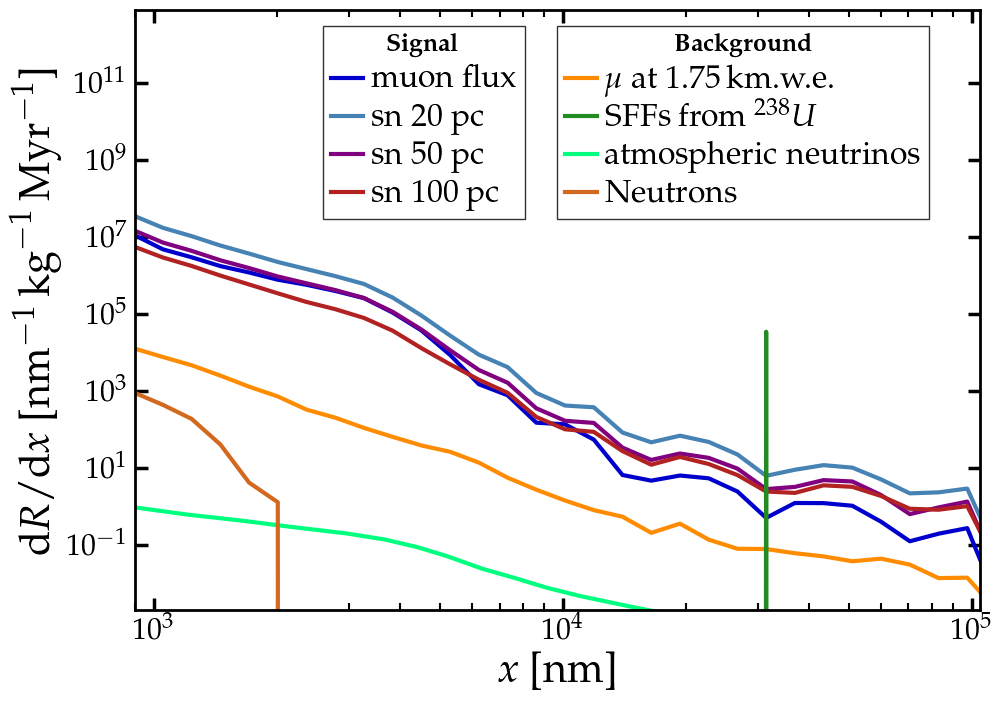

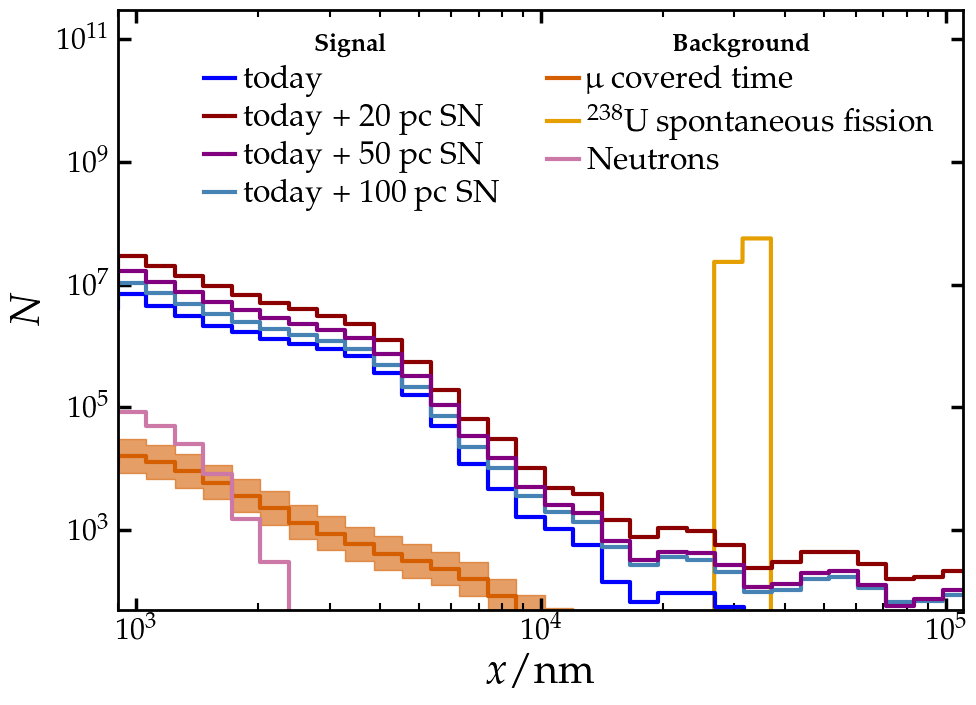

In [34]:
mass = 0.1
time = 5.97
time = 5.60
x_bins = np.logspace(x_min,x_max,n_bins)
size = 3
font_size = 30

plotSpectrum(mineral, dRdx, mineralname, Ufrac)
plotInt(x_bins, mass, time)
